# Global Path Variables

In [ ]:
base_path = "drive/MyDrive/Medical Data/"
EDA = "drive/MyDrive/Medical Data/EDA/"
pre_processing = "drive/MyDrive/Medical Data/PreProcessing/"
# resnet50 = "/content/drive/MyDrive/Medical Data/ResNet50/"
customCNN = "/content/drive/MyDrive/Medical Data/Custom_CNN/"

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import cv2
import gc

# Importing Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import (InputLayer, BatchNormalization, Dropout, Flatten, multiply,
                                     Dense, Activation, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D, SeparableConv2D, add, concatenate, DepthwiseConv2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam, RMSprop
from keras.metrics import Precision, Recall, AUC
from keras.backend import clear_session

# Image read and show
import skimage.io
from skimage.io import imread, imshow

# Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

2.12.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the Dataset from h5 file..


In [ ]:
def load_hdf5_data(hdf5_path):
    f = h5py.File(hdf5_path, 'r')
    return f['image'], f['image_name'], f['image_label']

train_images, train_names, train_labels = load_hdf5_data(f'{base_path}Dataset5_raw_train.h5')
val_images, val_names, val_labels = load_hdf5_data(f'{base_path}Dataset5_raw_val.h5')
test_images, test_names, test_labels = load_hdf5_data(f'{base_path}Dataset5_raw_test.h5')

In [ ]:
def shuffle_data(images, names, labels):
    # Convert the HDF5 datasets to numpy arrays
    images = np.array(images)
    names = np.array(names)
    labels = np.array(labels)

    # Generate shuffled indices
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)

    # Use these indices to shuffle your data
    shuffled_images = images[indices]
    shuffled_names = names[indices]
    shuffled_labels = labels[indices]

    return shuffled_images, shuffled_names, shuffled_labels

# Shuffle the training data
train_images, train_names, train_labels = shuffle_data(train_images, train_names, train_labels)

# Shuffle the validation data
val_images, val_names, val_labels = shuffle_data(val_images, val_names, val_labels)

# Shuffle the test data
test_images, test_names, test_labels = shuffle_data(test_images, test_names, test_labels)


In [ ]:
def get_label_counts(labels):
    # Convert the HDF5 dataset to a numpy array first
    labels_np = np.array(labels)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Create a dictionary of label to count
    label_counts = dict(zip(unique_labels, counts))

    return label_counts

train_label_counts = get_label_counts(train_labels)
val_label_counts = get_label_counts(val_labels)
test_label_counts = get_label_counts(test_labels)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)

Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}


# Class Label to Disease Name Mapping Dict

In [ ]:
"""
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
"""

Label_ClassName_Dict = {
    0 : "COVID-19",
    1 : "Lung-Opacity",
    2 : "Normal",
    3 : "Viral Pneumonia",
    4 : "Tuberculosis",
}

ClassName_Dict_Label  = {v: k for k, v in Label_ClassName_Dict.items()}

float32 0.0 0.99609375 (224, 224, 3) 3
float32 0.0 0.96875 (224, 224, 3) 3
float32 0.0 0.9765625 (224, 224, 3) 3
float32 0.003921509 0.953125 (224, 224, 3) 3
float32 0.0 0.8901367 (224, 224, 3) 3


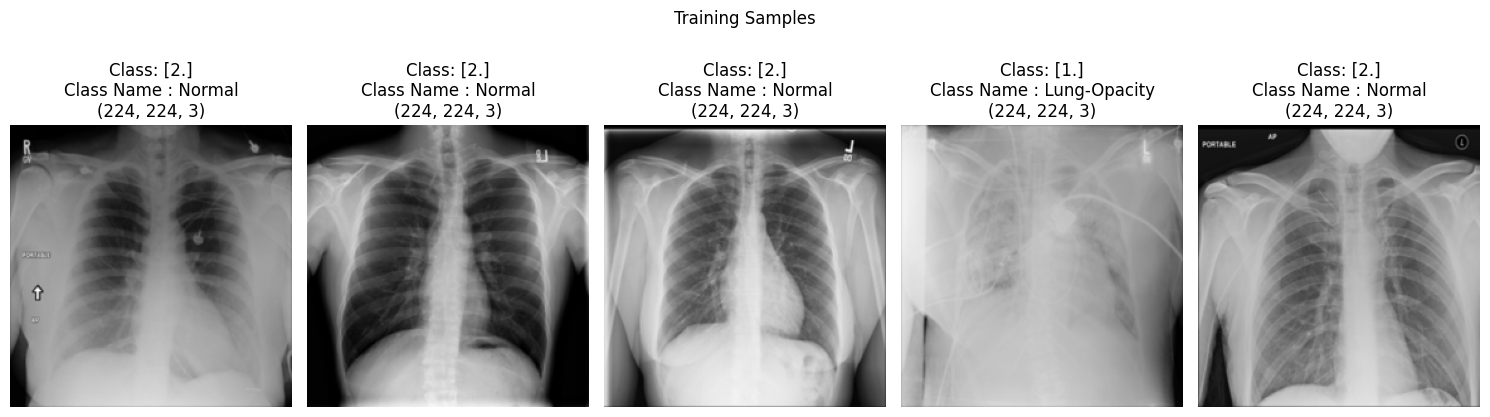

<Figure size 640x480 with 0 Axes>

In [ ]:

def display_samples(images, labels, path, num_samples=5, Type = "Training"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        image = images[i]
        # Normalize the image if its values are not in the range [0, 1]
        # Convert the image to a suitable dtype
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None) # Use gray colormap if the image is grayscale
        plt.title(f'Class: {labels[i]}\n' + f'Class Name : {Label_ClassName_Dict[int(labels[i].squeeze())]}\n' + f"{image.shape}")
        plt.axis('off')

    plt.suptitle(f"{Type} Samples")
    plt.tight_layout()
    plt.show()
    plt.savefig(path)

display_samples(train_images, train_labels, f"{pre_processing}Image_Samples.png")

# Image Pre-processing
1. CLAHE with grid size of 15 and clip size of 2.
2. Image Shapening with kernels.
3. Zoom for Handling Noise and Other Artifacts in the Dataset


*   Pre-Process : Hybrid CLAHE + Zoom + Image Sharpening




In [ ]:
"""
CLAHE
"""

# Function to apply CLAHE
def apply_clahe(img, grid_size=15, clip_limit=2.0):
    img = img.numpy()  # Convert tensor to numpy array
    img = img.astype(np.uint8)
    grid_size = int(grid_size)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(grid_size, grid_size))
    img_clahe = np.zeros_like(img)
    for channel in range(3):
        img_clahe[..., channel] = clahe.apply(img[..., channel])
    return img_clahe

"""
Image Shapening
"""

# kernels = [[[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]], # Basic Sharpening Kernel:
#            [[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]], # Laplacian Sharpening Kernel:
#            [[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]], # Diagonal Edge Sharpening:
#            [[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]], # Exaggerated Sharpening:
#            [[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]], # Another variant of Laplacian:
# ]

kernels = {
    "Basic Sharpening Kernel" : np.array([[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]]),
    "Laplacian Sharpening Kernel" : np.array([[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]]),
    "Diagonal Edge Sharpening" : np.array([[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]]) ,
    "Exaggerated Sharpening" : np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]]),
    "Another variant of Laplacian" : np.array([[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]],) ,
}

# Function to sharpen image
def sharpen_image(img, kernel= kernels["Basic Sharpening Kernel"]):
    img = img.numpy()
    img = img.astype(np.uint8)
    kernel = np.array(kernel)
    return cv2.filter2D(img, -1, kernel)


"""
Zoom Function - Handling Noise and Other Artifacts in the Dataset

1. Cropping / Zoom
2. Data Augmentation
3. Add Noise to the Images
"""

def zoom_into_chest_area(img, zoom_factor=0.83):
    """
    Zooms into the central region of a given X-ray image (assuming the chest area is centrally located).

    Args:
    - img_np: A numpy ndarray representing the X-ray image.
    - zoom_factor: Factor by which to zoom into the image. Values less than 1 zoom in.

    Returns:
    - A numpy ndarray representing the zoomed image.
    """
    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to zoom into
    center_x, center_y = img_np.shape[1] // 2, img_np.shape[0] // 2
    width_zoomed = img_np.shape[1] * zoom_factor
    height_zoomed = img_np.shape[0] * zoom_factor

    # Define ROI boundaries
    x1 = int(center_x - width_zoomed // 2)
    x2 = int(center_x + width_zoomed // 2)
    y1 = int(center_y - height_zoomed // 2)
    y2 = int(center_y + height_zoomed // 2)

    # Extract the region of interest from the image
    zoomed_roi = img_np[y1:y2, x1:x2]

    # Resize the ROI to the original image dimensions
    zoomed_img = cv2.resize(zoomed_roi, (img_np.shape[1], img_np.shape[0]))

    return zoomed_img

def crop_and_resize_image_np(img, crop_percentage=0.1):
    """
    Crops and then resizes a given image using numpy and OpenCV.

    Args:
    - img_np: A numpy ndarray representing the image.
    - crop_percentage: Percentage of the image's height to crop from each side.

    Returns:
    - A numpy ndarray representing the cropped and resized image.
    """

    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to crop
    height, width = img_np.shape[0], img_np.shape[1]

    # Calculate crop size
    crop_size = int(height * crop_percentage)

    # Get the coordinates to crop the image
    x1, x2 = crop_size, width - crop_size
    y1, y2 = crop_size, height - crop_size

    # Crop the image
    cropped_img = img_np[y1:y2, x1:x2]

    # Resize the cropped image to the original dimensions
    resized_img = cv2.resize(cropped_img, (width, height))

    return resized_img

def add_noise_np(img, stddev=0.1):
    """
    Adds Gaussian noise to a given numpy image.

    Args:
    - img_np: A numpy ndarray representing the image.
    - stddev: Standard deviation of the Gaussian noise.

    Returns:
    - A numpy ndarray representing the image with added noise.
    """
    img_np = img.numpy().copy().astype(np.uint8)
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Ensure the image is in float32 for the noise addition
    img_float = img_np.astype(np.float32)

    # Create noise and add to the image
    noise = np.random.normal(loc=0, scale=stddev, size=img_np.shape)
    noisy_img = img_float + noise

    # Clip values to [0, 255] if your image has pixel values in that range
    noisy_img_clipped = np.clip(noisy_img, 0, 255)

    # Convert back to uint8
    noisy_img_uint8 = noisy_img_clipped.astype(np.uint8)

    return noisy_img_uint8

"""
Pre-Process and Visualisation Functions
"""

# Apply CLAHE, zoom, and then sharpening transformations to images
def preprocess_images(image, label):
    image = tf.py_function(zoom_into_chest_area, [image], tf.uint8)
    image = tf.py_function(apply_clahe, [image], tf.uint8)
    image = tf.py_function(sharpen_image, [image], tf.uint8)
    return image, label


def rescale_image(img):
    return (img - img.min()) / (img.max() - img.min())

## Create Tensorflow Datasets from HDF5 files.


In [ ]:
# Create a TF Dataset
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

## Apply Pre-Processing

In [ ]:
with tf.device('/cpu:0'):
    # Training set Pre-Processing
    train_dataset_preprocessed = train_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Validation set Pre-Processing
    val_dataset_preprocessed = val_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Testing set Pre-Processing
    test_dataset_preprocessed = test_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Set Seed and Other Parameters

In [ ]:
Seed = 123
Batch_Size = 128
Image_Size = 224
num_classes = 5
BUFFER_SIZE = 19610
np.random.seed(Seed)
tf.random.set_seed(Seed)

# CustomCNN

1. Image preprocess

*   scaling + 0 centering
*   Shuffling, Batching and One Hot Encoding

2. Training from Scratch.



## Scaling and 0 centering

In [ ]:
"""
1. ResNet50 Pre Process
"""
# Scaling
def scaling(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
with tf.device('/cpu:0'):
    train_dataset_scaled = train_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset_scaled = val_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset_scaled = test_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Zero Centering
with tf.device('/cpu:0'):

    def accumulate_images(img, label):
        return tf.reduce_sum(img, axis=0), tf.shape(img)[0]

    # Map the accumulate function onto the dataset and reduce to get global sum and count
    accumulated_data = train_dataset_scaled.map(accumulate_images).reduce(
        (tf.zeros([224, 224, 3]), 0),
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )

    # Compute the mean
    mean_image = accumulated_data[0] / tf.cast(accumulated_data[1], tf.float32)


In [ ]:
# Zero-centering
def zero_center(image, label):
    return image - mean_image, label

with tf.device('/cpu:0'):
      # Apply zero-centering to the datasets
      train_dataset_scaled_centered = train_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      val_dataset_scaled_centered = val_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      test_dataset_scaled_centered = test_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)


## Shuffling the images

In [ ]:
print(f"Buffer Size : {BUFFER_SIZE}")

# train_dataset_normalized = train_dataset_normalized.shuffle(BUFFER_SIZE)
train_dataset_scaled_centered = train_dataset_scaled_centered.shuffle(4096)
# test_dataset_scaled_centered = test_dataset_scaled_centered.shuffle(2048)
val_dataset_scaled_centered = val_dataset_scaled_centered.shuffle(4096)

Buffer Size : 19610


## Scaling , Batching and One Hot Encoding

In [ ]:
num_classes = 5

def one_hot_encode_batched(images, labels):
    labels = tf.cast(labels, tf.int32)
    labels = tf.one_hot(labels, depth=num_classes)
    labels = tf.squeeze(labels, axis = 1)  # Remove unnecessary dimensions
    return images, labels

In [ ]:
# Scaled , 0 centered dataset Batch and Prefetch
train_dataset_scaled_centered_batched_onehot = (train_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_scaled_centered_batched_onehot = (val_dataset_scaled_centered
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_scaled_centered_batched_onehot = (test_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

## Fine Tuning train_dataset_scaled_centered_batched_onehot Dataset.


In [ ]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Disease Diagnosis from CXR images - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{customCNN}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
# sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{customCNN}{path}")
    #plt.show()

In [ ]:
# GCW : Global Class Based Weighting
total_samples = 2512 + 3607 + 6115 + 4438 + 2938

# Calculate the global class-based weights
weights = {
    'COVID-19':  total_samples / (num_classes * 2512),
    'Lung-Opacity':  total_samples / (num_classes * 3607),
    'Normal':  total_samples / (num_classes * 6115),
    'Viral Pneumonia':  total_samples / (num_classes * 4438),
    'Tuberculosis':  total_samples / (num_classes * 2938)
}

int_weights = {ClassName_Dict_Label[key]: value for key, value in weights.items()}
print(int_weights)

{0: 1.5613057324840764, 1: 1.0873301912947047, 2: 0.6413736713000817, 3: 0.8837314105452907, 4: 1.334921715452689}


In [ ]:
steps_per_epoch = total_samples // Batch_Size
print('steps per epoch: ',steps_per_epoch + 1)

steps per epoch:  154


## Delete un-necessary Files to free up System Ram.

In [ ]:
del mean_image
del test_images, test_dataset, test_dataset_preprocessed, test_dataset_scaled, test_dataset_scaled_centered
del train_images, train_dataset, train_dataset_preprocessed, train_dataset_scaled, train_dataset_scaled_centered
del val_images, val_dataset, val_dataset_preprocessed, val_dataset_scaled, val_dataset_scaled_centered
del test_labels, train_labels, val_labels

In [ ]:
del train_names, val_names, test_names
gc.collect()

0

In [ ]:
def count_images_in_batched_dataset(dataset):
    count = 0
    for batch in dataset:
        count += batch[0].shape[0]  # Assuming batch is a tuple of (images, labels)
    return count

print(count_images_in_batched_dataset(train_dataset_scaled_centered_batched_onehot))
print(count_images_in_batched_dataset(val_dataset_scaled_centered_batched_onehot))
print(count_images_in_batched_dataset(test_dataset_scaled_centered_batched_onehot))

19610
6534
6540


In [ ]:
# Count samples per class per batch for the first 20 batches
for i, (_, labels) in enumerate(train_dataset_scaled_centered_batched_onehot.take(20)):
    class_counts = tf.reduce_sum(labels, axis=0)
    print(f"Batch {i+1} class counts: {class_counts.numpy()}")

Batch 1 class counts: [10. 24. 44. 33. 17.]
Batch 2 class counts: [16. 20. 39. 26. 27.]
Batch 3 class counts: [15. 24. 34. 41. 14.]
Batch 4 class counts: [12. 15. 43. 36. 22.]
Batch 5 class counts: [16. 16. 39. 34. 23.]
Batch 6 class counts: [11. 30. 49. 22. 16.]
Batch 7 class counts: [17. 23. 32. 39. 17.]
Batch 8 class counts: [17. 18. 42. 29. 22.]
Batch 9 class counts: [15. 37. 41. 25. 10.]
Batch 10 class counts: [17. 25. 49. 17. 20.]
Batch 11 class counts: [14. 24. 51. 23. 16.]
Batch 12 class counts: [12. 27. 43. 28. 18.]
Batch 13 class counts: [20. 26. 31. 28. 23.]
Batch 14 class counts: [19. 20. 41. 30. 18.]
Batch 15 class counts: [12. 22. 43. 37. 14.]
Batch 16 class counts: [11. 27. 41. 33. 16.]
Batch 17 class counts: [12. 30. 37. 33. 16.]
Batch 18 class counts: [21. 26. 37. 30. 14.]
Batch 19 class counts: [23. 24. 36. 28. 17.]
Batch 20 class counts: [12. 27. 42. 27. 20.]


## CNN - From Scratch

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# def spatial_attention(input_feature):
#     kernel_size = 3  # Reduced from 7 to 3

#     if input_feature.shape[-1] != 1:
#         channel_attention = Conv2D(1, kernel_size, strides=1, padding='same', activation='sigmoid')(input_feature)
#     else:
#         channel_attention = input_feature

#     return multiply([input_feature, channel_attention])

# def feature_branch(inputs, filters):
#     x = DepthwiseConv2D(3, padding='same', activation='relu')(inputs)
#     x = Conv2D(filters, 1, activation='relu')(x)
#     x = MaxPooling2D(3)(x)
#     x = spatial_attention(x)
#     return x

# def custom_complex_model(input_shape):
#     inputs = Input(shape=input_shape)

#     branch_a = feature_branch(inputs, 16)  # Reduced to 16 from 32
#     branch_b = feature_branch(inputs, 32)  # Reduced to 32 from 64
#     branch_c = feature_branch(inputs, 64)  # Reduced to 64 from 128

#     concat = concatenate([branch_a, branch_b, branch_c], axis=-1)

#     x = DepthwiseConv2D(3, padding='same', activation='relu')(concat)
#     x = Conv2D(64, 1, activation='relu')(x)  # Reduced to 64 from 128
#     x = MaxPooling2D(3)(x)

#     x = add([x, spatial_attention(x)])

#     x = DepthwiseConv2D(3, padding='same', activation='relu')(x)
#     x = Conv2D(128, 1, activation='relu')(x)  # Reduced to 128 from 256
#     x = MaxPooling2D(3)(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)  # Reduced to 1024 from 4096
#     x = Dropout(0.5)(x)
#     x = Dense(1024, activation='relu')(x)  # Reduced to 1024 from 4096
#     x = Dropout(0.5)(x)
#     outputs = Dense(5, activation='softmax')(x)  # Assuming 5 classes

#     model = Model(inputs, outputs)

#     return model


In [ ]:
def spatial_attention(input_feature, layer_num=0):
    kernel_size = 3

    if input_feature.shape[-1] != 1:
        channel_attention = Conv2D(1, kernel_size, padding='same', activation='sigmoid',
                                   name=f'spatialAttention_conv_{layer_num}')(input_feature)
    else:
        channel_attention = input_feature

    return multiply([input_feature, channel_attention],
                    name=f'spatialAttention_multiply_{layer_num}')

def vgg_block(x, filters, block_num):


    x = Conv2D(filters, (3,3), padding='same', name=f'vggBlock_{block_num}_conv_1')(x)
    x = BatchNormalization(name=f'vggBlock_{block_num}_bn_1')(x)
    x = Activation('relu', name=f'vggBlock_{block_num}_act_1')(x)

    x = Conv2D(filters, (3,3), padding='same', name=f'vggBlock_{block_num}_conv_2')(x)
    x = BatchNormalization(name=f'vggBlock_{block_num}_bn_2')(x)
    x = Activation('relu', name=f'vggBlock_{block_num}_act_2')(x)

    # Introduce spatial attention before pooling in the VGG block
    x = spatial_attention(x, layer_num=f'prePoolVGG_{block_num}')
    return MaxPooling2D(name=f'vggBlock_{block_num}_pool')(x)

def simplified_residual_block(x, filters, block_num):
    skip = x  # This is the bypass or skip connection

    # Pass through the VGG block
    vgg = vgg_block(x, filters, block_num)

    # Adjust skip connection for channel mismatch
    if x.shape[-1] != vgg.shape[-1]:
        skip = Conv2D(filters, (1,1), padding='same', name=f'resBlock_{block_num}_adjust_conv')(skip)
        skip = BatchNormalization(name=f'resBlock_{block_num}_adjust_bn')(skip)

    # Adjust skip connection for spatial mismatch
    if skip.shape[1] != vgg.shape[1] or skip.shape[2] != vgg.shape[2]:
        skip = MaxPooling2D(name=f'resBlock_{block_num}_adjust_pool')(skip)

    return add([vgg, skip], name=f'resBlock_{block_num}_add')

def custom_architecture(input_shape):
    inputs = Input(input_shape, name='input_layer')

    # Introduce spatial attention before the VGG block
    x = spatial_attention(inputs, layer_num=f'preVGG_Spatial_Attention')

    # VGG-like blocks with residual connections and spatial attention
    filters = [32, 64, 128, 256]
    for idx, filter in enumerate(filters):
        x = simplified_residual_block(x, filter, block_num=idx+1)

    # Final layers
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(1024, activation='relu', name='dense_2')(x)
    outputs = Dense(5, activation='softmax', name='output_layer')(x)  # Assuming 5 classes

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = custom_architecture((224,224,3))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 spatialAttention_conv_preVGG_S  (None, 224, 224, 1)  28         ['input_layer[0][0]']            
 patial_Attention (Conv2D)                                                                        
                                                                                                  
 spatialAttention_multiply_preV  (None, 224, 224, 3)  0          ['input_layer[0][0]',            
 GG_Spatial_Attention (Multiply                                   'spatialAttention_conv_preVG

In [ ]:
# def spatial_attention(input_feature):
#     kernel_size = 3  # Reduced from 7 to 3

#     if input_feature.shape[-1] != 1:
#         channel_attention = Conv2D(1, kernel_size, strides=1, padding='same', activation='sigmoid')(input_feature)
#     else:
#         channel_attention = input_feature

#     return multiply([input_feature, channel_attention])

# def feature_branch(inputs, filters):
#     x = DepthwiseConv2D(3, padding='same')(inputs)
#     # x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters, 1)(x)
#     # x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = MaxPooling2D()(x)
#     x = spatial_attention(x)
#     return x


# from tensorflow.keras.regularizers import l2

# def custom_complex_model(input_shape, reg_factor=0.0001):
#     inputs = Input(shape=input_shape)

#     branch_a = feature_branch(inputs, 16)
#     branch_b = feature_branch(inputs, 32)
#     branch_c = feature_branch(inputs, 64)

#     concat = concatenate([branch_a, branch_b, branch_c], axis=-1)

#     # Block 1
#     x_shortcut = concat
#     x = DepthwiseConv2D(3, padding='same')(concat)
#     # x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     # x = Dropout(0.3)(x)  # Increased Dropout

#     x = Conv2D(64, 1)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Adjust x_shortcut to match the number of filters in x
#     x_shortcut = Conv2D(64, 1, activation='linear', use_bias=False)(x_shortcut)
#     x_shortcut = BatchNormalization()(x_shortcut)

#     x = add([x, x_shortcut]) # Residual connection
#     x = MaxPooling2D()(x)
#     x = Dropout(0.5)(x)  # Increased Dropout

#     # Block 2
#     # x_shortcut = x
#     # x = DepthwiseConv2D(3, padding='same')(x)
#     # x = BatchNormalization()(x)
#     # x = Activation('relu')(x)
#     # x = Dropout(0.3)(x)  # Increased Dropout

#     # x = Conv2D(64, 1)(x)
#     # x = BatchNormalization()(x)
#     # x = Activation('relu')(x)

#     # # Adjust x_shortcut to match the number of filters in x
#     # x_shortcut = Conv2D(64, 1, activation='linear', use_bias=False)(x_shortcut)
#     # x_shortcut = BatchNormalization()(x_shortcut)

#     # x = add([x, x_shortcut]) # Residual Connection
#     # x = MaxPooling2D(3)(x)
#     # x = Dropout(0.5)(x)  # Increased Dropout

#     # Final layers
#     x = GlobalAveragePooling2D()(x)
#     # x = Dense(1024, activation='relu', kernel_regularizer=l2(reg_factor))(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     # x = Dense(1024, activation='relu', kernel_regularizer=l2(reg_factor))(x)
#     x = Dense(1024, activation='relu')(x)

#     outputs = Dense(5, activation='softmax')(x)  # Assuming 5 classes

#     model = Model(inputs, outputs)
#     return model


In [ ]:
# # Spatial Attention Layer
# def spatial_attention(input_feature):
#     # Set the kernel size for the convolutional operation
#     kernel_size = 7

#     # Check if the input feature map has more than one channel.
#     # If it does, we apply a 2D convolution to generate the attention map.
#     if input_feature.shape[-1] != 1:
#         # Apply a convolution operation with a kernel size of 7x7, a stride of 1, and same padding.
#         # This convolution layer compresses the channel dimension from the input depth to 1.
#         # The sigmoid activation function ensures the output values are in the range [0, 1], which represent attention scores.
#         channel_attention = Conv2D(1, kernel_size, strides=1, padding='same', activation='sigmoid')(input_feature)
#     else:
#         # If the input feature map has only one channel, we don't need to reduce its depth.
#         # So, we directly use the input as the attention map.
#         channel_attention = input_feature

#     # Multiply the original input feature map with the attention map.
#     # This operation is element-wise, so each spatial location in the input feature map is scaled by the corresponding value in the attention map.
#     # Regions with higher attention scores will be amplified, while regions with lower scores will be attenuated.
#     return multiply([input_feature, channel_attention])


# # Feature extraction branch
# def feature_branch(inputs, filters):
#     x = DepthwiseConv2D(3, padding='same', activation='relu')(inputs)
#     x = BatchNormalization()(x)
#     x = Conv2D(filters, 1, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(3)(x)
#     x = spatial_attention(x)
#     return x

# def custom_complex_model(input_shape):
#     inputs = Input(shape=input_shape)

#     # Multi-Scale Feature Extraction branches
#     branch_a = feature_branch(inputs, 32)
#     branch_b = feature_branch(inputs, 64)
#     branch_c = feature_branch(inputs, 128)

#     # Concatenate multi-scale features
#     concat = concatenate([branch_a, branch_b, branch_c], axis=-1)

#     # Main stream
#     x = DepthwiseConv2D(3, padding='same', activation='relu')(concat)
#     x = BatchNormalization()(x)
#     x = Conv2D(128, 1, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(3)(x)

#     x = add([x, spatial_attention(x)])  # Skip connection with attention

#     x = DepthwiseConv2D(3, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(256, 1, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(3)(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(4096, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
#     x = Dense(4096, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(5, activation='softmax')(x)  # 5 classes as per your dataset

#     model = Model(inputs, outputs)

#     return model

input_shape = (224, 224, 3)  # Adjust based on your dataset

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

# Model Compilation
with tf.device('/gpu:0'):
  model = custom_architecture(input_shape)
  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=METRICS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 spatialAttention_conv_preVGG_S  (None, 224, 224, 1)  28         ['input_layer[0][0]']            
 patial_Attention (Conv2D)                                                                        
                                                                                                  
 spatialAttention_multiply_preV  (None, 224, 224, 3)  0          ['input_layer[0][0]',            
 GG_Spatial_Attention (Multiply                                   'spatialAttention_conv_pre

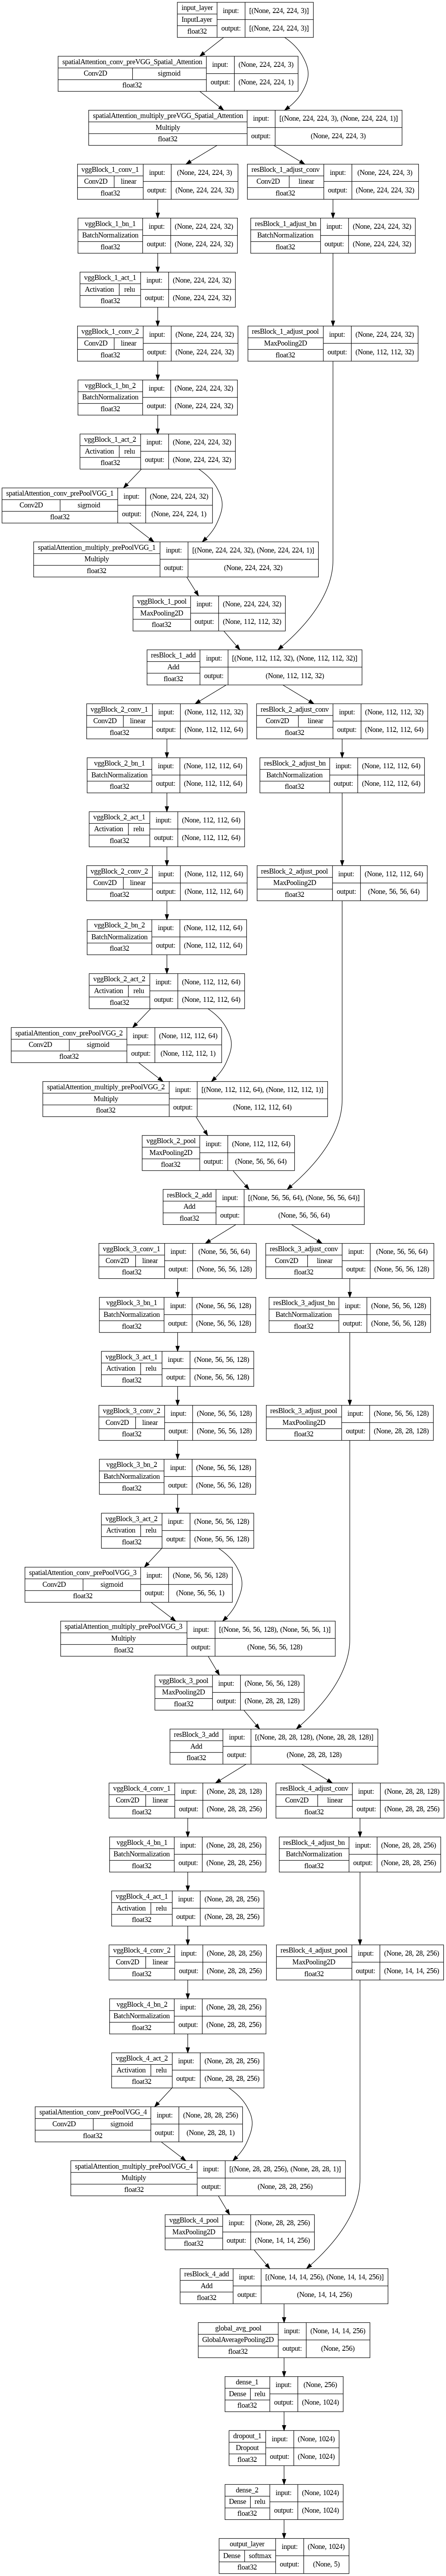

In [ ]:
plot_model(
    model,
    to_file=f"{customCNN}Architecture_ResnetBlock.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [ ]:
# Hyperparameters and Callback Settings
epochs = 100
lr_reduction_factor = 0.3
lr_patience = 5
min_lr = 0.000000001
early_stopping_patience = 15
best_model_path = f"{customCNN}customCNN_attention_Resnet_Block.h5"

lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                              factor=lr_reduction_factor,
                              patience=lr_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)

early_stopping_cb = EarlyStopping(monitor='val_auc',
                                  patience=early_stopping_patience,
                                  restore_best_weights=True,
                                  verbose=1,
                                  mode="max")

checkpoint_cb = ModelCheckpoint(best_model_path,
                                monitor='val_auc',
                                save_best_only=True,
                                verbose=1,
                                mode="max")

# Train the model
with tf.device('/gpu:0'):
    history_customCNN_scaled_batched = model.fit(
        train_dataset_scaled_centered_batched_onehot,
        epochs=epochs,
        validation_data=val_dataset_scaled_centered_batched_onehot,
        verbose = 1,
        class_weight=int_weights,
        callbacks = [lr_reduce, early_stopping_cb],)

Epoch 1/100
154/154 [==============================] - 150s 825ms/step - loss: 1.0134 - accuracy: 0.8616 - precision: 0.7755 - recall: 0.4337 - auc: 0.8751 - val_loss: 2.7602 - val_accuracy: 0.7016 - val_precision: 0.1899 - val_recall: 0.1507 - val_auc: 0.5037 - lr: 1.0000e-04
Epoch 2/100
154/154 [==============================] - 139s 816ms/step - loss: 0.6424 - accuracy: 0.9084 - precision: 0.8201 - recall: 0.6945 - auc: 0.9496 - val_loss: 5.7901 - val_accuracy: 0.6504 - val_precision: 0.1248 - val_recall: 0.1244 - val_auc: 0.4585 - lr: 1.0000e-04
Epoch 3/100
154/154 [==============================] - 140s 823ms/step - loss: 0.5107 - accuracy: 0.9278 - precision: 0.8514 - recall: 0.7742 - auc: 0.9671 - val_loss: 4.1766 - val_accuracy: 0.6741 - val_precision: 0.1692 - val_recall: 0.1610 - val_auc: 0.5476 - lr: 1.0000e-04
Epoch 4/100
154/154 [==============================] - 139s 819ms/step - loss: 0.4363 - accuracy: 0.9381 - precision: 0.8699 - recall: 0.8121 - auc: 0.9753 - val_loss

### Plot

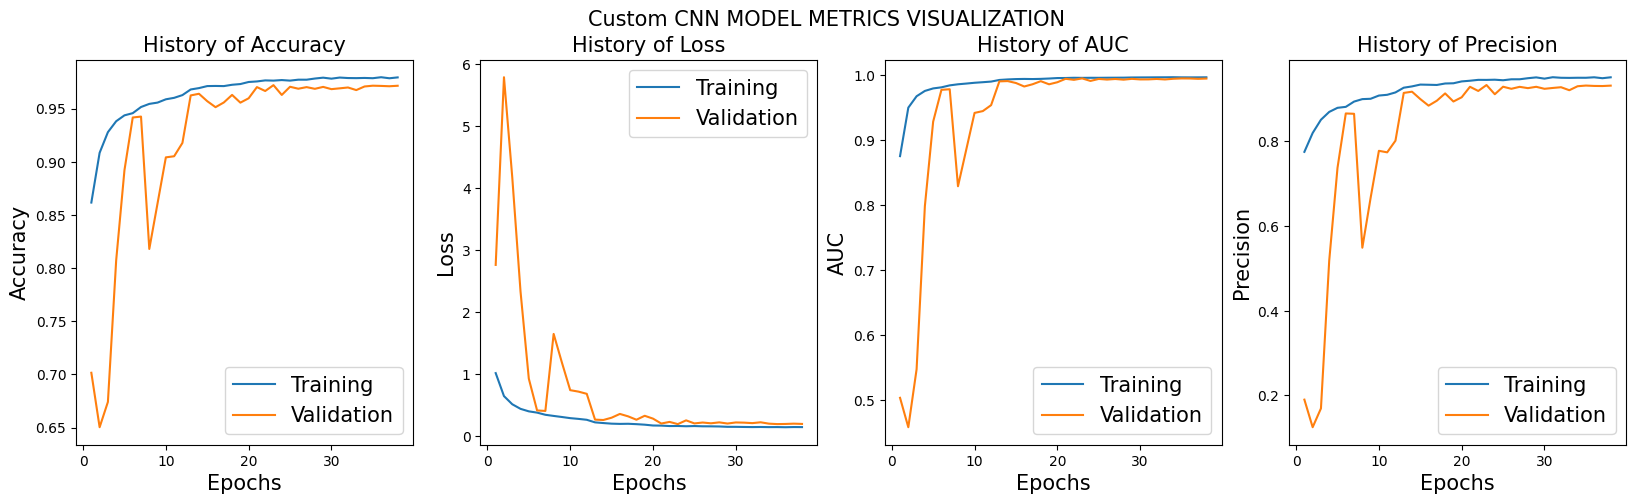

In [ ]:
path = "loss_acc.png"
title = "Custom CNN MODEL METRICS VISUALIZATION"
Eval_Plot(
    history_customCNN_scaled_batched.history['accuracy'],history_customCNN_scaled_batched.history['val_accuracy'],
    history_customCNN_scaled_batched.history['loss'],history_customCNN_scaled_batched.history['val_loss'],
    history_customCNN_scaled_batched.history['auc'],history_customCNN_scaled_batched.history['val_auc'],
    history_customCNN_scaled_batched.history['precision'],history_customCNN_scaled_batched.history['val_precision'],
    path, title
)

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from keras.saving.saving_api import load_weights
with tf.device('/gpu:0'):
    # best_model_path = f"{customCNN}customCNN_attention.h5"
    best_model_path = f"{customCNN}customCNN_attention_Resnet_Block.h5"
    # model.save(best_model_path)
    model.load_weights(filepath=f'{best_model_path}')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 spatialAttention_conv_preVGG_S  (None, 224, 224, 1)  28         ['input_layer[0][0]']            
 patial_Attention (Conv2D)                                                                        
                                                                                                  
 spatialAttention_multiply_preV  (None, 224, 224, 3)  0          ['input_layer[0][0]',            
 GG_Spatial_Attention (Multiply                                   'spatialAttention_conv_pre

In [ ]:
# Getting predictions
with tf.device('/gpu:0'):
    predictions = model.predict(test_dataset_scaled_centered_batched_onehot)

y_pred = predictions.argmax(axis=-1)

# Retrieving labels from dataset
y_labels_list = []
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Here, we're assuming that the labels are one-hot encoded
    # So, we get the integer label for each sample in the batch
    y_labels_list.append(tf.argmax(labels, axis=-1))

# Stacking batches together
y_label = tf.concat(y_labels_list, axis=0).numpy()

# Retrieve class names from the ClassName_Dict_Label
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]

52/52 [==============================] - 331s 6s/step


In [ ]:
assert y_pred.shape == y_label.shape

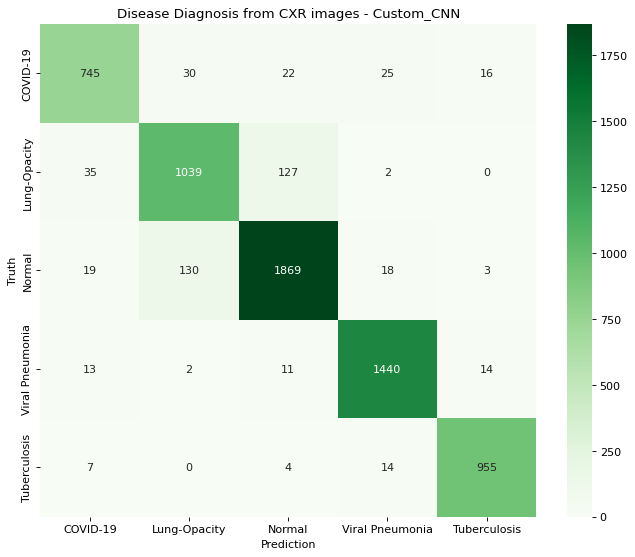

In [ ]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"HeatMap.jpeg", "Custom_CNN")

In [ ]:
print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       838
           1       0.87      0.86      0.86      1203
           2       0.92      0.92      0.92      2039
           3       0.96      0.97      0.97      1480
           4       0.97      0.97      0.97       980

    accuracy                           0.92      6540
   macro avg       0.92      0.92      0.92      6540
weighted avg       0.92      0.92      0.92      6540



### Scores

In [ ]:
scores_Custom_CNN = model.evaluate(test_dataset_scaled_centered_batched_onehot)

52/52 [==============================] - 26s 500ms/step - loss: 0.2087 - accuracy: 0.9700 - precision: 0.9285 - recall: 0.9209 - auc: 0.9930


In [ ]:
print(f"Accuracy in test set  : {scores_Custom_CNN[1]}")
print(f"Precision in test set : {scores_Custom_CNN[2]}")
print(f"Recall in test set    : {scores_Custom_CNN[3]}")
print(f"AUC in test set       : {scores_Custom_CNN[4]}")

Accuracy in test set  : 0.9700000286102295
Precision in test set : 0.9284723401069641
Recall in test set    : 0.9209480285644531
AUC in test set       : 0.9929628968238831


In [ ]:
import pandas as pd
Scores = pd.DataFrame([scores_Custom_CNN], columns = ["Loss", "Test Accuracy", "Precision", "Recall", "AUC"])
Scores

,Loss,Test Accuracy,Precision,Recall,AUC
0,0.208691,0.97,0.928472,0.920948,0.992963


In [ ]:
Scores.to_csv(f"{customCNN}score.csv")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 spatialAttention_conv_preVGG_S  (None, 224, 224, 1)  28         ['input_layer[0][0]']            
 patial_Attention (Conv2D)                                                                        
                                                                                                  
 spatialAttention_multiply_preV  (None, 224, 224, 3)  0          ['input_layer[0][0]',            
 GG_Spatial_Attention (Multiply                                   'spatialAttention_conv_pre

# Spatial Attention Map Visualization

In [ ]:
# Extracting the layer names
for layer in model.layers:
    print('Layer name:', layer.name)

Layer name: input_layer
Layer name: spatialAttention_conv_preVGG_Spatial_Attention
Layer name: spatialAttention_multiply_preVGG_Spatial_Attention
Layer name: vggBlock_1_conv_1
Layer name: vggBlock_1_bn_1
Layer name: vggBlock_1_act_1
Layer name: vggBlock_1_conv_2
Layer name: vggBlock_1_bn_2
Layer name: vggBlock_1_act_2
Layer name: spatialAttention_conv_prePoolVGG_1
Layer name: resBlock_1_adjust_conv
Layer name: spatialAttention_multiply_prePoolVGG_1
Layer name: resBlock_1_adjust_bn
Layer name: vggBlock_1_pool
Layer name: resBlock_1_adjust_pool
Layer name: resBlock_1_add
Layer name: vggBlock_2_conv_1
Layer name: vggBlock_2_bn_1
Layer name: vggBlock_2_act_1
Layer name: vggBlock_2_conv_2
Layer name: vggBlock_2_bn_2
Layer name: vggBlock_2_act_2
Layer name: spatialAttention_conv_prePoolVGG_2
Layer name: resBlock_2_adjust_conv
Layer name: spatialAttention_multiply_prePoolVGG_2
Layer name: resBlock_2_adjust_bn
Layer name: vggBlock_2_pool
Layer name: resBlock_2_adjust_pool
Layer name: resBlock_

In [ ]:
from scipy.ndimage import zoom

# Create new models to extract attention maps
# Extracting the output from the 'multiply_1' layer for branch 'a'
# attention_model_a = Model(inputs=model.input, outputs=model.get_layer("spatialAttention_multiply_prePoolVGG_4").output)

# # Extracting the output from the 'multiply_2' layer for branch 'b'
# attention_model_b = Model(inputs=model.input, outputs=model.get_layer("spatialAttention_multiply_prePoolVGG_4").output)

# # Extracting the output from the 'multiply_3' layer for branch 'c'
# attention_model_c = Model(inputs=model.input, outputs=model.get_layer("spatialAttention_multiply_prePoolVGG_4").output)


def resize_attention(attention_map, original_shape):
    # print(attention_map.shape)
    if len(attention_map.shape) == 3:
      attention_map = np.squeeze(attention_map)
    # print(attention_map.shape)
    original_spatial_shape = original_shape[:2]
    attention_spatial_shape = attention_map.shape[:2]

    zoom_factor = (original_spatial_shape[0] / attention_spatial_shape[0],
                   original_spatial_shape[1] / attention_spatial_shape[1])

    # Create an empty array to store resized attentions
    resized_attention = np.zeros((original_spatial_shape[0], original_spatial_shape[1], attention_map.shape[2]))

    # Apply zoom to each channel separately
    for channel in range(attention_map.shape[2]):
        resized_attention[:, :, channel] = zoom(attention_map[:, :, channel], zoom_factor, order=1)

    return resized_attention

def plot_attention(attention_map, original_image, ax):
    resized_attention = resize_attention(attention_map, original_image.shape[:2])
    avg_attention = np.mean(resized_attention, axis=-1)
    im = ax.imshow(rescale_image(original_image), cmap='gray', interpolation='bilinear')
    cax = ax.imshow(avg_attention, cmap='jet', alpha=0.5, interpolation='bilinear')
    ax.axis("off")
    return cax

def rescale_image(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

# # Extract sample images
# sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
# sample_images = sample_images.numpy()

# sample_labels = np.argmax(sample_labels, axis=1) # Convert one-hot to class indices

# sample_images = sample_images[:10]  # Select the first 10 images

# # Get one batch of test images and labels
# for idx, test_image in enumerate(sample_images):
#     fig, axes = plt.subplots(1, 4, figsize=(15, 5))

#     # Original Image
#     axes[0].imshow(rescale_image(test_image), cmap='gray')
#     axes[0].axis("off")
#     axes[0].set_title("Original")

#     test_image = np.expand_dims(test_image, axis=0)

#     # Predict attention maps for the image
#     attention_map_a = attention_model_a.predict(test_image)
#     attention_map_b = attention_model_b.predict(test_image)
#     attention_map_c = attention_model_c.predict(test_image)

#     # print(attention_map_a.shape, attention_map_b.shape, attention_map_c.shape)

#     # Get the prediction
#     predictions = model.predict(test_image)
#     pred_label = np.argmax(predictions, axis=1)[0]

#     fig.suptitle(f"True Label: {Label_ClassName_Dict[int(sample_labels[idx])]}, Predicted Label: {Label_ClassName_Dict[int(pred_label)]}", fontsize=14)

#     # Visualize attention maps for the image
#     cax_a = plot_attention(attention_map_a[0], test_image[0], axes[1])
#     axes[1].set_title("Attention A")
#     fig.colorbar(cax_a, ax=axes[1], shrink=0.6)

#     cax_b = plot_attention(attention_map_b[0], test_image[0], axes[2])
#     axes[2].set_title("Attention B")
#     fig.colorbar(cax_b, ax=axes[2], shrink=0.6)

#     cax_c = plot_attention(attention_map_c[0], test_image[0], axes[3])
#     axes[3].set_title("Attention C")
#     fig.colorbar(cax_c, ax=axes[3], shrink=0.6)

#     plt.tight_layout()
#     plt.show()


In [ ]:
attention_layer_names = [
    "spatialAttention_multiply_preVGG_Spatial_Attention",
    "spatialAttention_multiply_prePoolVGG_1",
    "spatialAttention_multiply_prePoolVGG_2",
    "spatialAttention_multiply_prePoolVGG_3",
    "spatialAttention_multiply_prePoolVGG_4"
]

attention_models = [Model(inputs=model.input, outputs=model.get_layer(layer_name).output) for layer_name in attention_layer_names]

layer_titles = {
    "spatialAttention_multiply_preVGG_Spatial_Attention": "Attention Pre-VGG",
    "spatialAttention_multiply_prePoolVGG_1": "Attention Pre-Pool 1",
    "spatialAttention_multiply_prePoolVGG_2": "Attention Pre-Pool 2",
    "spatialAttention_multiply_prePoolVGG_3": "Attention Pre-Pool 3",
    "spatialAttention_multiply_prePoolVGG_4": "Attention Pre-Pool 4"
}


In [ ]:
# Define the functions as previously mentioned, such as resize_attention, plot_attention, and rescale_image

# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = np.argmax(sample_labels, axis=1) # Convert one-hot to class indices

sample_images = sample_images[:10]  # Select the first 10 images

# Iterate over images
for idx, test_image in enumerate(sample_images):
    fig, axes = plt.subplots(1, 6, figsize=(20, 4))  # 6 columns for 1 original image + 5 attention maps

    # Original Image
    axes[0].imshow(rescale_image(test_image), cmap='gray')
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    test_image = np.expand_dims(test_image, axis=0)
    predictions = model.predict(test_image)
    pred_label = np.argmax(predictions, axis=1)[0]
    fig.suptitle(f"True Label: {Label_ClassName_Dict[int(sample_labels[idx])]}, Predicted Label: {Label_ClassName_Dict[int(pred_label)]}", fontsize=14, y=1.05)

    # Extract attention maps and visualize them
    for i, (attention_model, layer_name) in enumerate(zip(attention_models, attention_layer_names)):
        attention_map = attention_model.predict(test_image)
        cax = plot_attention(attention_map[0], test_image[0], axes[i+1])
        axes[i+1].set_title(layer_titles[layer_name])
        fig.colorbar(cax, ax=axes[i+1], shrink=0.6)

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.